In [92]:
!pip install -q -U watermark

In [93]:
!pip install -qq transformers

In [94]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.21.0

numpy       : 1.26.4
pandas      : 2.2.2
torch       : 2.4.0
transformers: 4.44.0



In [95]:
import transformers
from transformers import BertModel, BertTokenizer
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from collections import defaultdict
from textwrap import wrap

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [96]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

In [97]:
df = pd.read_csv("/kaggle/input/google-play-reviews-of-top-25-productivity-tools/reviews.csv")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId
0,a4540892-992d-48e8-ac56-89aa4ac9199d,Pat Lentz,https://play-lh.googleusercontent.com/a/ACg8oc...,I used this app for many years and it worked f...,1,3,v11432,2024-05-23 12:01:14,"Hi Pat, we're truly sorry to hear about this! ...",2024-05-24 15:43:43,v11432,most_relevant,com.todoist
1,c591a9c3-fef3-4db6-96d2-8d45ab2cc852,Zach LaMarca,https://play-lh.googleusercontent.com/a-/ALV-U...,"Downloaded the app to try it, which it wanted ...",1,6,NaN,2024-07-17 15:46:03,NaN,NaN,NaN,most_relevant,com.todoist
2,864a3d8e-7863-4b28-9062-aed1b8e8281b,Darkest Love,https://play-lh.googleusercontent.com/a-/ALV-U...,Didn't notice ive used this app before (memory...,1,2,v10532,2022-10-11 22:15:26,Hello! We are very sorry to hear about the cra...,2022-10-13 13:01:14,v10532,most_relevant,com.todoist
3,7007f861-8aad-4070-b3f5-bf4f3bee6a00,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,I'm doing what I decry - leaving a bad review ...,1,2,NaN,2019-01-11 01:56:10,NaN,NaN,NaN,most_relevant,com.todoist
4,a676cc0e-0e50-431f-bc05-d513d627e208,Amber Knowlton,https://play-lh.googleusercontent.com/a/ACg8oc...,"What is the point of a ""To Do"" list without re...",1,10,NaN,2021-03-18 15:31:37,NaN,NaN,NaN,most_relevant,com.todoist


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28014 entries, 0 to 28013
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              28014 non-null  object
 1   userName              28012 non-null  object
 2   userImage             28014 non-null  object
 3   content               28009 non-null  object
 4   score                 28014 non-null  int64 
 5   thumbsUpCount         28014 non-null  int64 
 6   reviewCreatedVersion  24967 non-null  object
 7   at                    28014 non-null  object
 8   replyContent          7923 non-null   object
 9   repliedAt             7923 non-null   object
 10  appVersion            24967 non-null  object
 11  sortOrder             28014 non-null  object
 12  appId                 28014 non-null  object
dtypes: int64(2), object(11)
memory usage: 2.8+ MB


In [99]:
df.score.unique()

array([1, 2, 3, 4, 5])

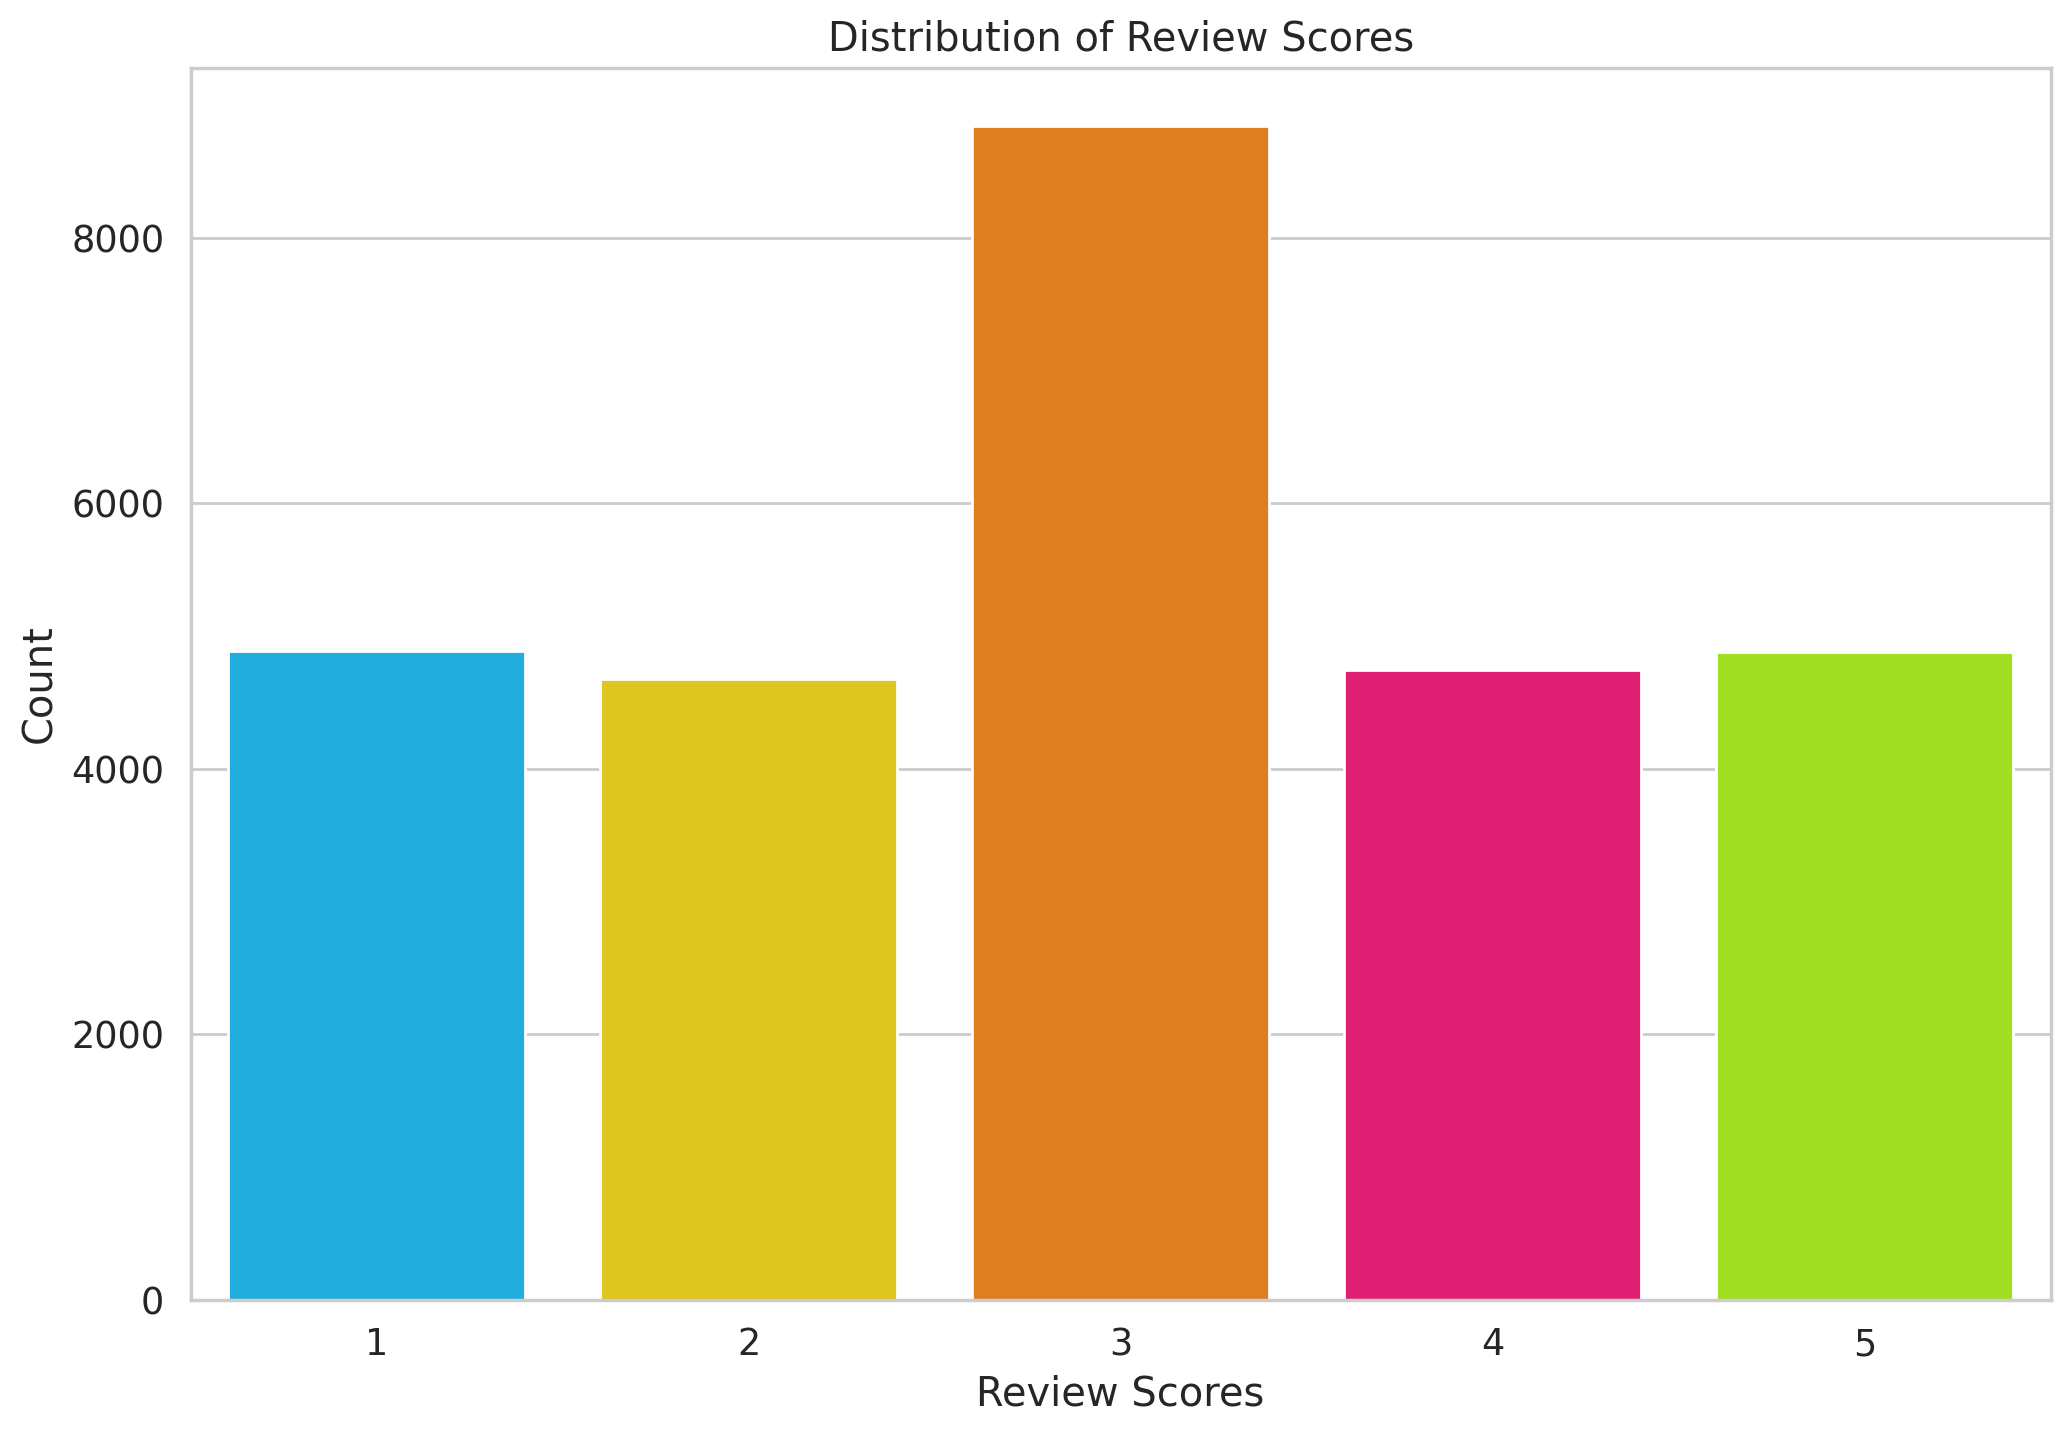

In [100]:
sns.countplot(x='score', data=df)

plt.title('Distribution of Review Scores')
plt.xlabel('Review Scores')
plt.ylabel('Count')
plt.show()

In [101]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else: 
        return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [102]:
class_names = ['negative', 'neutral', 'positive']

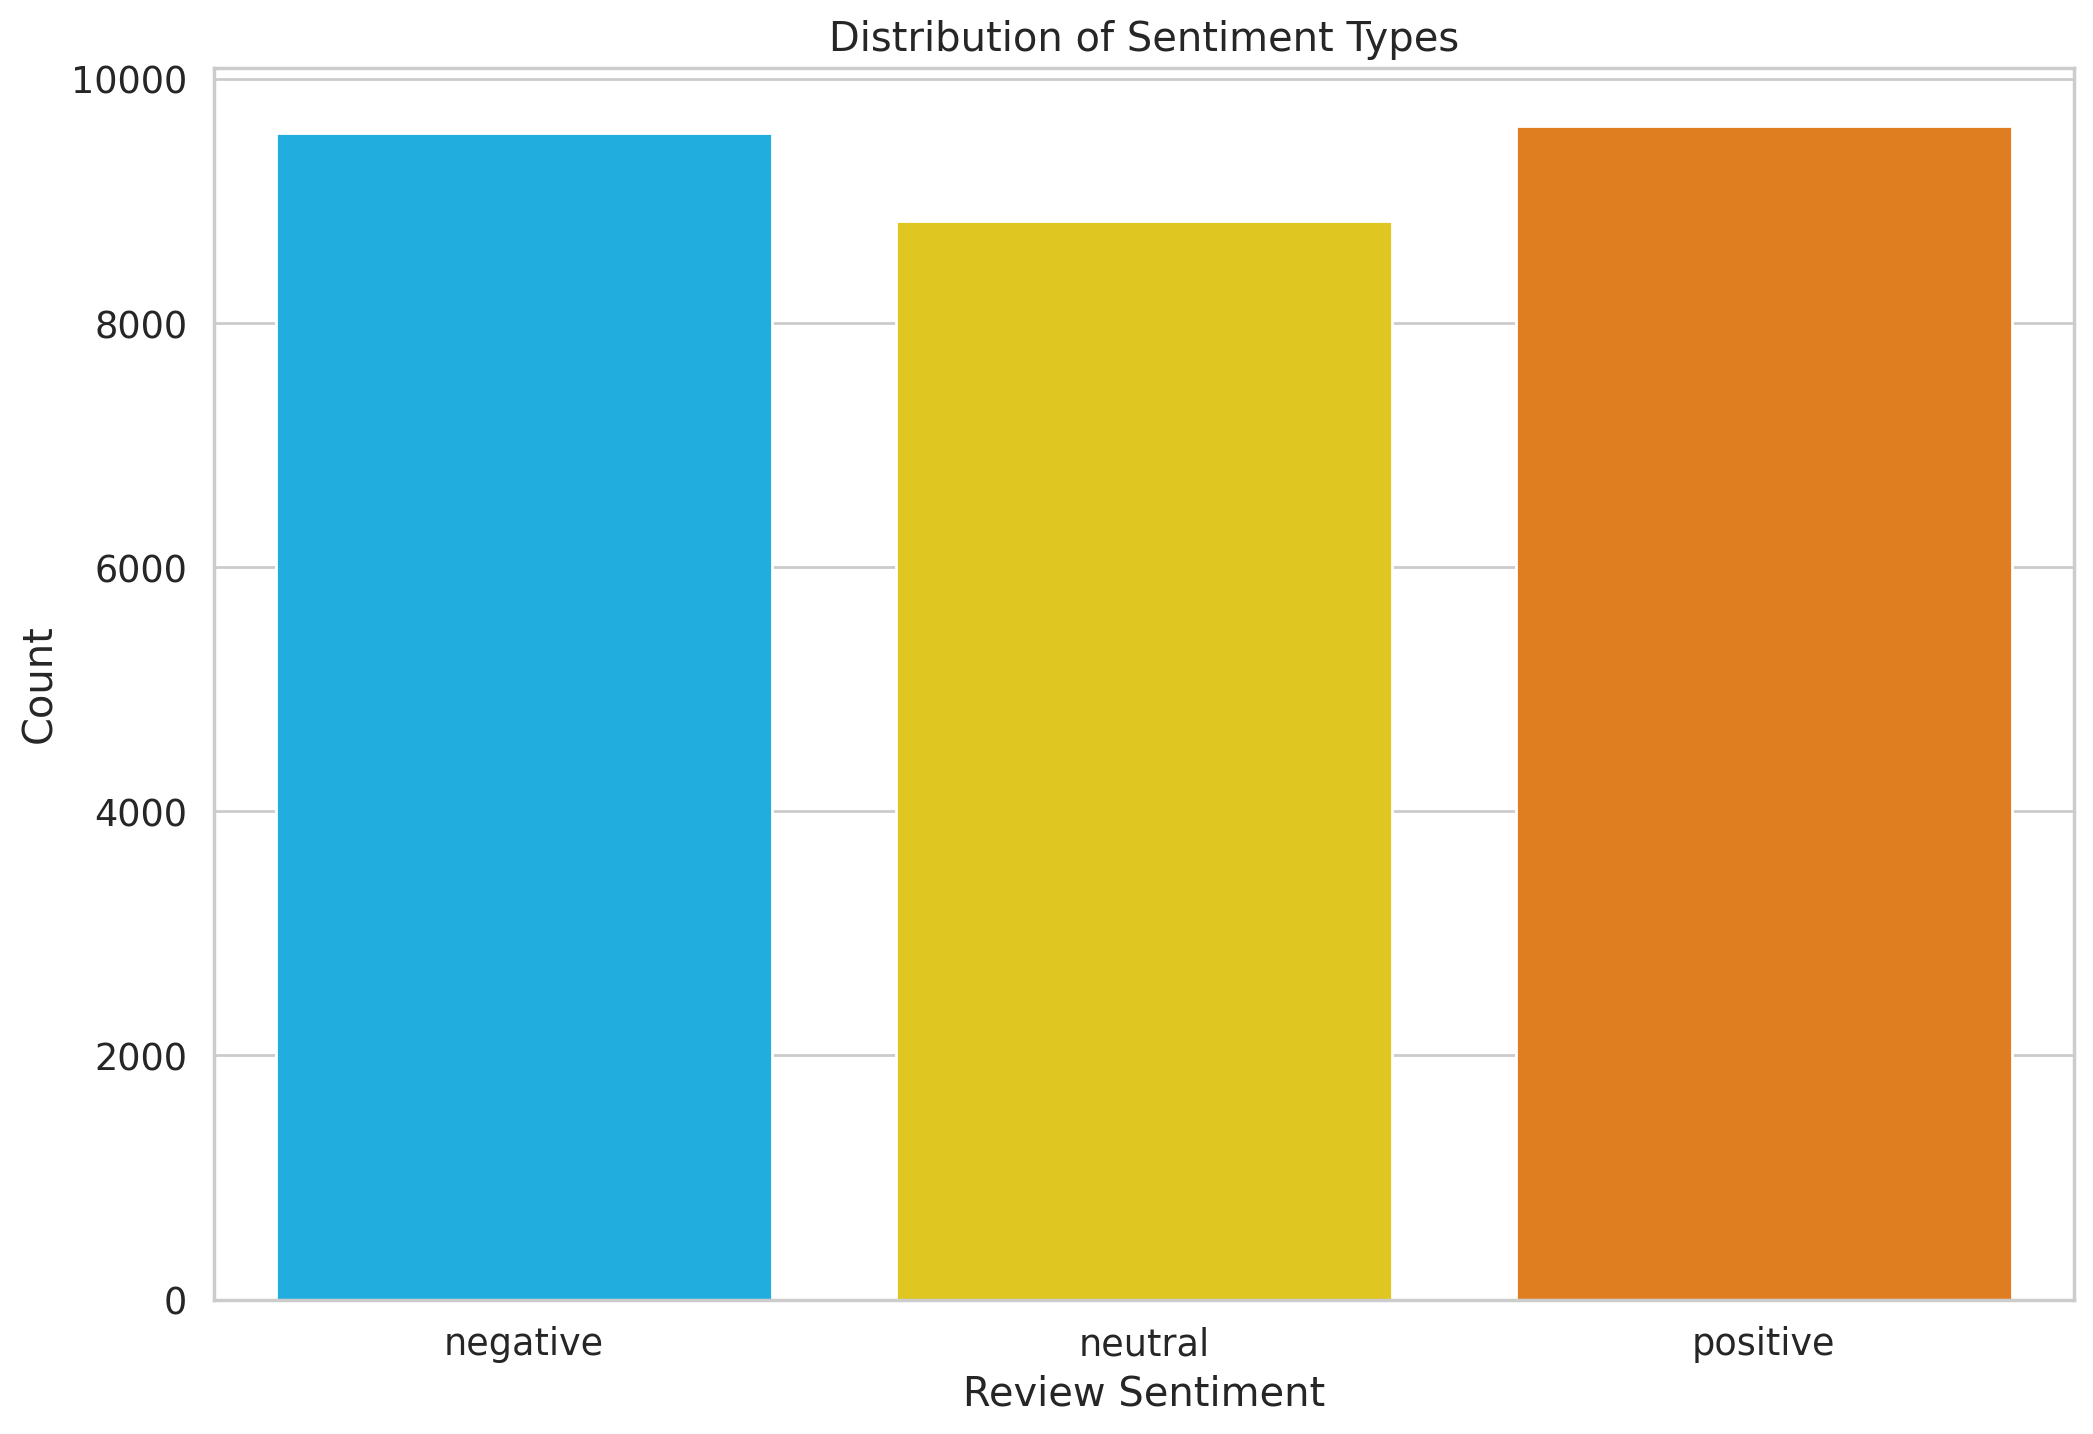

In [103]:
ax = sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiment Types')
plt.xlabel('Review Sentiment')
plt.ylabel('Count')
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(class_names);
plt.show()

# Data Preprocessing

For ML, we have to convert text to numbers. BERT requires even more attention. Here are the requirements:

* Add special tokens to separate sentences and do classification
* Pass sequences of constant length (introduce padding)
* Create array of 0s (pad token) and 1s (real token) called attention mask

In [104]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

You can use a cased and uncased version of BERT and tokenizer. I've experimented with both. The cased version works better. Intuitively, that makes sense, since "BAD" might convey more sentiment than "bad".

In [105]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [106]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [107]:

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


# Special Tokens

In [108]:
tokenizer.sep_token, tokenizer.sep_token_id # [SEP] - marker for ending of a sentence

('[SEP]', 102)

In [109]:
tokenizer.cls_token, tokenizer.cls_token_id 
# [CLS] - we must add this token to the start of each sentence, so BERT knows we're doing classification

('[CLS]', 101)

In [110]:
tokenizer.pad_token, tokenizer.pad_token_id
# Special token for padding

('[PAD]', 0)

In [111]:
tokenizer.unk_token, tokenizer.unk_token_id
# unknown token

('[UNK]', 100)

In [112]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'attention_mask'])

In [113]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [114]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [115]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']